In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F #relu,GD
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from torchvision.transforms import Resize, RandomHorizontalFlip,RandomVerticalFlip,RandomGrayscale
from PIL import Image, ImageOps

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    Resize((460,325)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.1),
    RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor()
])

In [4]:
train_root = r"/kaggle/input/gender-classification/Gender Dataset/train"
valid_root = r"/kaggle/input/gender-classification/Gender Dataset/valid"
test_root = r"/kaggle/input/gender-classification/Gender Dataset/test"

In [5]:
train_dataset = ImageFolder(train_root , transform=transform)
valid_dataset = ImageFolder(valid_root,transform=transforms.Compose([transforms.ToTensor(),Resize((460,325))]))
test_dataset = ImageFolder(test_root,transform=transforms.Compose([transforms.ToTensor(),Resize((460,325))]))

train_loader = DataLoader(train_dataset,batch_size = 64,shuffle = True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size = 4,shuffle=False,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size = 4,shuffle=False,drop_last=True)

In [6]:
train_dataset.classes

['Female', 'Male']

In [7]:
train_dataset.class_to_idx
valid_dataset.class_to_idx


{'Female': 0, 'Male': 1}

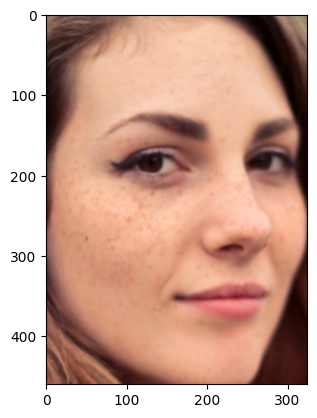

In [8]:
sample_image, _ = train_dataset[0]  
transform = transforms.ToPILImage()
sample_image = transform(sample_image)
plt.imshow(sample_image)
plt.show()

In [9]:
#Pretraind Model
model = vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(device)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 36.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
optimizer = optim.Adam(model.classifier.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 60

for epoch in range(epochs):
    total_train_loss = 0.0
    total_train_samples = 0
    total_train_correct = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_samples += data.size(0)

        # Calculate training accuracy after each batch
        _, predictions = scores.max(1)
        total_train_correct += (predictions == targets).sum().item()

    # Calculate average training loss per epoch and Accuracy
    epoch_train_loss = (total_train_loss / total_train_samples)
    train_losses.append(epoch_train_loss)
    
    epoch_train_accuracy = (total_train_correct / total_train_samples)*100
    train_accuracies.append(epoch_train_accuracy)


    # Validation Loop
    model.eval()
    num_correct = 0
    num_samples = 0
    total_val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate (valid_loader):
            x = x.to(device)
            y = y.to(device)    

            scores = model(x)
            loss = criterion(scores, y)
            total_val_loss += loss.item() 

            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

        val_acc = (float(num_correct) /float(num_samples)) * 100
        val_loss = total_val_loss / num_samples
        # Calculate average validation loss per epoch and Accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} | Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')
# Classification report for validation data
val_report = classification_report(val_targets, val_predictions, target_names=train_dataset.classes)
print("Classification Report - Validation Data:")
print(val_report)

model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/60 | Validation Accuracy: 79.65 | Validation Loss: 0.1475
Epoch 2/60 | Validation Accuracy: 87.79 | Validation Loss: 0.1252
Epoch 3/60 | Validation Accuracy: 88.95 | Validation Loss: 0.1108
Epoch 4/60 | Validation Accuracy: 88.95 | Validation Loss: 0.1013
Epoch 5/60 | Validation Accuracy: 86.63 | Validation Loss: 0.0957
Epoch 6/60 | Validation Accuracy: 89.53 | Validation Loss: 0.0895
Epoch 7/60 | Validation Accuracy: 88.95 | Validation Loss: 0.0860
Epoch 8/60 | Validation Accuracy: 89.53 | Validation Loss: 0.0831
Epoch 9/60 | Validation Accuracy: 88.95 | Validation Loss: 0.0807
Epoch 10/60 | Validation Accuracy: 88.95 | Validation Loss: 0.0787
Epoch 11/60 | Validation Accuracy: 86.05 | Validation Loss: 0.0779
Epoch 12/60 | Validation Accuracy: 88.95 | Validation Loss: 0.0759
Epoch 13/60 | Validation Accuracy: 89.53 | Validation Loss: 0.0750
Epoch 14/60 | Validation Accuracy: 88.95 | Validation Loss: 0.0738
Epoch 15/60 | Validation Accuracy: 89.53 | Validation Loss: 0.0731
Epoc

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

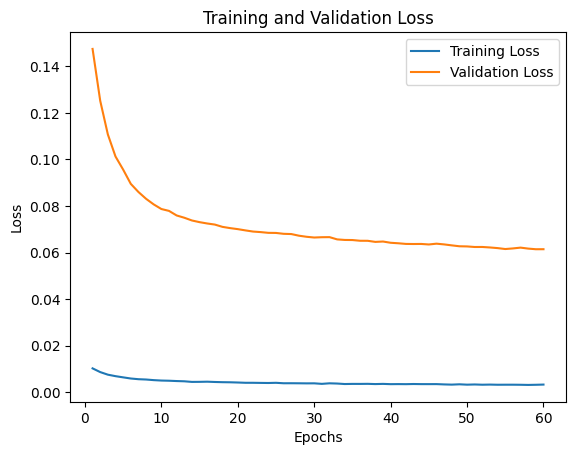

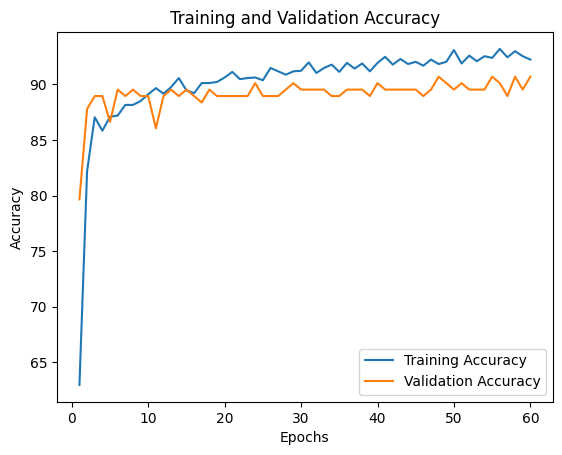

In [12]:
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Accuracy plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [13]:
# Testing Loop
model.eval()
num_correct = 0
num_samples = 0
test_loss = 0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        scores = model(x)
        loss = criterion(scores,y)
        test_loss += loss.item()
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum().item()
        num_samples += predictions.size(0)
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y.cpu().numpy())

test_acc = (float(num_correct) / float(num_samples)) * 100
test_loss /= num_samples

print(f'Testing Accuracy: {test_acc:.2f}| Testing_loss:{test_loss:.4f}')
test_report = classification_report(test_targets, test_predictions, target_names=test_dataset.classes)
print("Classification Report - Testing Data:")
print(test_report)
model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Testing Accuracy: 95.54| Testing_loss:0.0419
Classification Report - Testing Data:
              precision    recall  f1-score   support

      Female       1.00      0.91      0.95        55
        Male       0.92      1.00      0.96        57

    accuracy                           0.96       112
   macro avg       0.96      0.95      0.96       112
weighted avg       0.96      0.96      0.96       112



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1